# Turtle Trading Strategy

## Project Overview
In addition to the [Streamlit App](https://turtle-trader.streamlit.app/), this notebook will also serve as my main exploration space for testing and refining ideas before integrating any features into the Streamlit app.

### Asset Correlation Analysis
In trend-following strategies like Turtle Trading, understanding correlations is crucial because, because it helps traders to allocate capital more effectively and to avoid overexposure to the same risk factors, ensuring that they are not overly reliant on similar price movements across multiple positions.

Based on the correlation analysis, one can implement follwoing following rules

- Select assets with correlations below 0.7
- Prioritize assets with higher liquidity
- Use correlation-weighted position sizing
- Define maximum exposure per correlation cluster

Since risk management is the core building block of the strategy, it's important to note the original position thresholds used by the Turtles to limit portfolio risk

**Risk Management in Units (Max Units)**
- Single Market: 4
- Closely Correlated Market: 6
- Loosely Correlated Market: 10
- Single Direction—Long/Short: 12


In [19]:
# 1.1.1 Correlation Analysis for Crypto Assets

import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from datetime import datetime, timedelta
import yfinance as yf

import math
from datetime import datetime, timedelta

In [21]:
# Set ticker list, date range
start_date = "2020-01-01"
end_date = "2024-12-31"

#crypto
ticker_list = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'DOGE-USD']

#etfs
#ticker_list = ['QQQ', 'SPY', 'IWM', 'COPX','URA', 'SOXX', 'IXC', 'IXJ', 'GLD', 'SLV', 'SOYB', 'CORN', 'WEAT']

#stocks
#ticker_list = ['LLY', 'NVDA', 'AMD', 'ON', 'TSLA', 'FIVE', 'RAA.DE', 'DG', 'DGH', 'TJX', 'BAC', 'PG', 'XOM', 'JPM', 'DIS', 'CAT', 'MCD']

#ticker_list = ['SB=F', 'CL=F', 'HO=F', 'GC=F', 'SI=F', 'HG=F', 'WC=F', 'CC=F', 'OJ=F', 'ZS=F']

*Note*:
- SB=F : Sugar Futures  
- CL=F : Crude Oil Futures  
- HO=F : Heating Oil Futures  
- GC=F : Gold Futures  
- SI=F : Silver Futures  
- HG=F : Copper Futures  
- WC=F : Wheat Futures  
- CC=F : Cocoa Futures  
- OJ=F : Orange Juice Futures  
- ZS=F : Soybean Futures  

In [24]:
# Get data
def get_data(ticker_list, start_date, end_date):
    """
    Fetch data from yfinance and prepare it for backtrader.
    """
    df = yf.download(ticker_list, start_date, end_date, group_by="ticker")
    df_close = df.xs('Close', level=1, axis=1)
    
    return df_close

In [26]:
df_raw_data = get_data(ticker_list, start_date, end_date)
df_raw_data = df_raw_data.stack().reset_index()
df_raw_data.columns = ["date", "ticker", "close"]
df_raw_data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


,date,ticker,close
0,2020-01-01,BTC-USD,7200.174316
1,2020-01-01,ETH-USD,130.802002
2,2020-01-01,XRP-USD,0.192667
3,2020-01-01,DOGE-USD,0.002033
4,2020-01-02,BTC-USD,6985.470215
...,...,...,...
7299,2024-12-29,DOGE-USD,0.314320
7300,2024-12-30,BTC-USD,92643.210938
7301,2024-12-30,ETH-USD,3356.392578
7302,2024-12-30,XRP-USD,2.057571


In [28]:
# Transform data to calculate daily percentage changes in closing prices
def transform_data(df):
    """
    Transform the raw data to include daily closing percentage changes.
    """
    # Convert date to datetime and sort
    df["date"] = pd.to_datetime(df["date"])
    df.sort_values(by=["ticker", "date"], inplace=True)

    # Calculate daily percentage changes in closing prices
    df["daily_return"] = df.groupby("ticker")["close"].pct_change() * 100

    # Drop rows where 'daily_change' is NaN
    df.dropna(subset=["daily_return"], inplace=True)
    
    # Select relevant fields
    transformed_data = df[[
        "ticker", "date", "close", "daily_return"
    ]]
    return transformed_data

In [30]:
df_transformed_data = transform_data(df_raw_data)

In [32]:
# Check for missing values
missing_data = df_transformed_data.isnull().sum()
print("Missing data per ticker:")
missing_data

Missing data per ticker:


ticker          0
date            0
close           0
daily_return    0
dtype: int64

In [34]:
def calculate_correlations(df):
    """
    Calculate and plot the correlation matrix of daily returns.
    """
    # Pivot table: ticker as columns, dates as rows
    pivot = df.pivot(index="date", columns="ticker", values="daily_return")
       
    # Calculate correlation matrix
    corr_matrix = pivot.corr()

    # Plot correlation heatmap
    plt.figure(figsize=(15, 12))
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap='coolwarm', 
                fmt='.2f',
                cbar=True,
                square=True)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

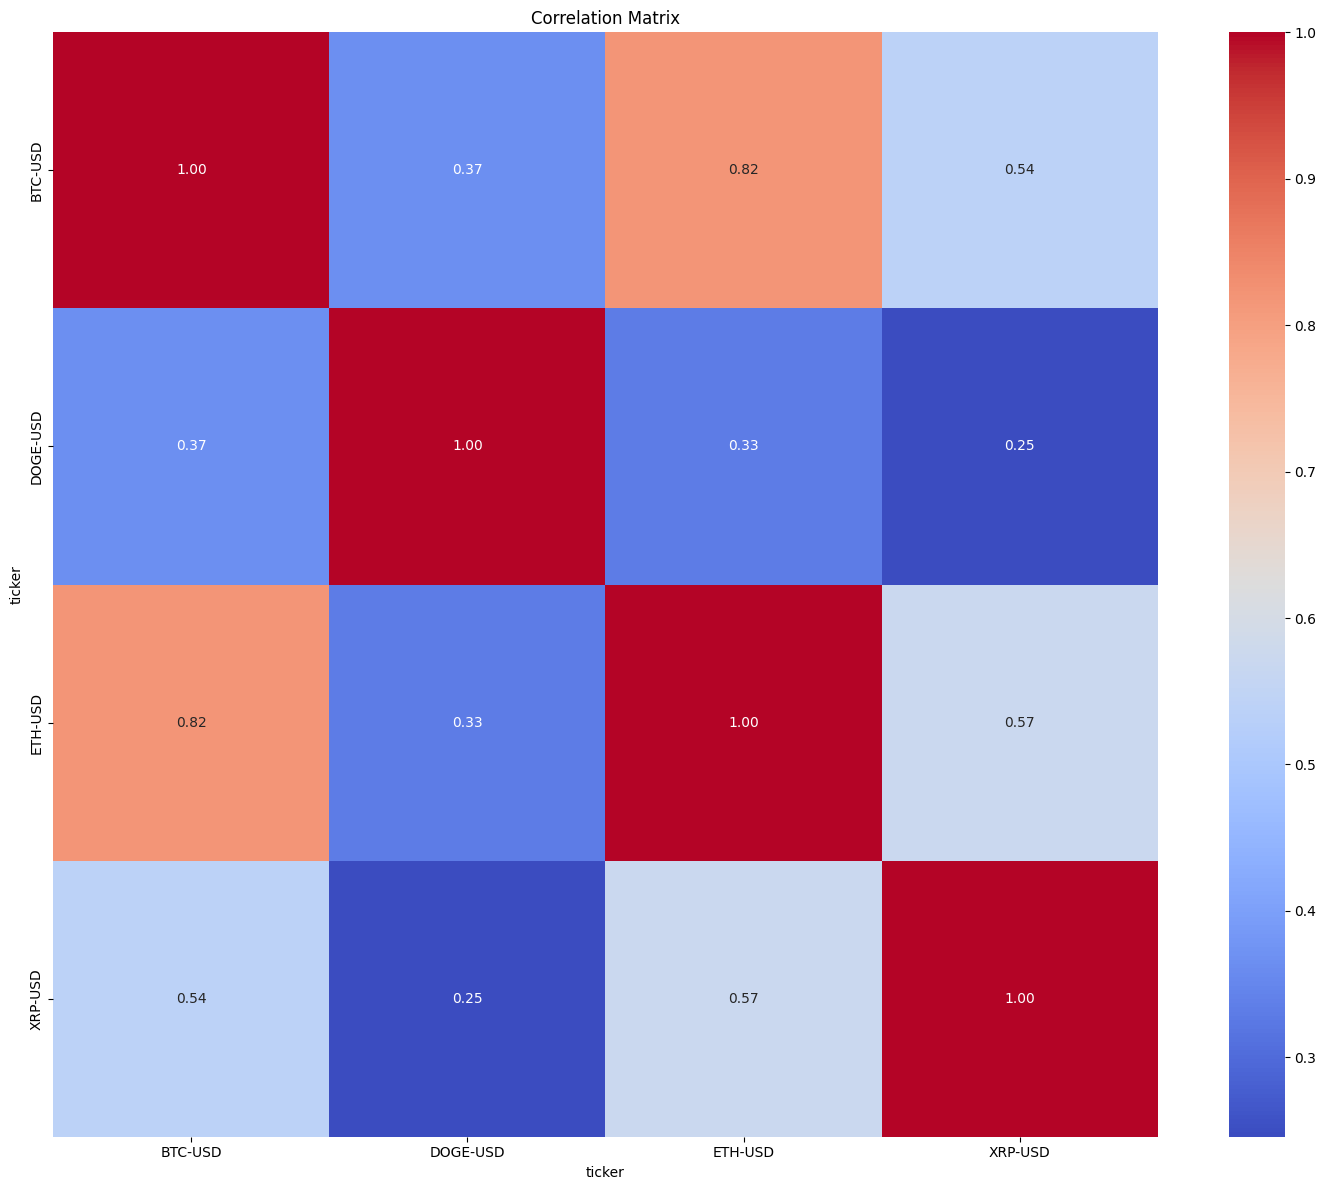

In [36]:
correlation_matrix = calculate_correlations(df_transformed_data)

In [38]:
def analyze_top_correlation_pairs(corr_matrix, high_threshold=0.7, low_threshold=0.6, top_n=5):
    """
    Analyze correlation matrix to identify top highly and less correlated pairs
    """
    high_corr_pairs = []
    low_corr_pairs = []
    
    # Get upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find pairs in different correlation ranges
    for col in upper.columns:
        # High correlations
        high_corr = upper[col][upper[col] >= high_threshold]
        for idx, value in high_corr.items():
            high_corr_pairs.append({
                'Asset 1': col,
                'Asset 2': idx,
                'Correlation': value
            })
            
        # Low correlations
        low_corr = upper[col][upper[col] < low_threshold]
        for idx, value in low_corr.items():
            low_corr_pairs.append({
                'Asset 1': col,
                'Asset 2': idx,
                'Correlation': value
            })
    
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False).head(top_n)
    low_corr_df = pd.DataFrame(low_corr_pairs).sort_values('Correlation', ascending=True).head(top_n)
    
    return high_corr_df, low_corr_df

In [40]:
# Analyze high correlations
high_correlations, low_correlations = analyze_top_correlation_pairs(correlation_matrix, 
                                                                    high_threshold=0.7, 
                                                                    low_threshold=0.7,
                                                                    top_n=5)

print("\nHighly Correlated Pairs (>= 0.7):")
print(high_correlations)

print("\nLess Correlated Pairs (< 0.7):")
print(low_correlations)

print("\nCorrelation Statistics:")
print(f"Average Correlation: {correlation_matrix.mean().mean():.3f}")
print(f"Median Correlation: {correlation_matrix.median().median():.3f}")


Highly Correlated Pairs (>= 0.7):
   Asset 1  Asset 2  Correlation
0  ETH-USD  BTC-USD     0.817362

Less Correlated Pairs (< 0.7):
    Asset 1   Asset 2  Correlation
3   XRP-USD  DOGE-USD     0.245772
1   ETH-USD  DOGE-USD     0.329484
0  DOGE-USD   BTC-USD     0.365944
2   XRP-USD   BTC-USD     0.540183
4   XRP-USD   ETH-USD     0.571788

Correlation Statistics:
Average Correlation: 0.609
Median Correlation: 0.617


## Parameter Optimization 

### To optimize the Turtle Trading strategy, the following script will run a simple grid search over various parameters to identify the best combinations that perform well across multiple asset classes.

Please note that a simple grid search is one way to find optimal parameters, but it’s not always the most efficient, especially when the search space is large. I will explore more advanced methods later, such as Walk-Forward Optimization (WFO), Reinforcement Learning (RL), and others.

In [44]:
# Import libs and frameworks
import backtrader as bt

import itertools
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [46]:
class PortfolioValue(bt.Analyzer):
    """
    Analyzer to track portfolio value over time.
    """
    def __init__(self):
        self.values = []

    def next(self):
        self.values.append(self.strategy.broker.getvalue())

class TradeTracker:
    """
    Track open and closed trades, and calculate best/worst trades.
    """
    def __init__(self):
        self.trades = []
        self.open_trades = {}
        self.trade_counter = 1

    def add_open_trade(self, trade_info):
        """
        Add a new open trade to the tracker.
        """
        trade_id = self.trade_counter
        self.open_trades[trade_id] = {
            'trade_id': trade_id,
            'entry_date': trade_info['entry_date'],
            'entry_price': trade_info['entry_price'],
            'size': trade_info['size']
        }
        self.trade_counter += 1
        return trade_id

    def add_closed_trade(self, trade_id, trade_info):
        """
        Add a closed trade to the tracker and remove it from open trades.
        """
        trade_info['trade_id'] = trade_id
        self.trades.append(trade_info)
        if trade_id in self.open_trades:
            del self.open_trades[trade_id]

    def get_best_worst_trades(self):
        """
        Return the best and worst trades based on net PnL.
        """
        if not self.trades:
            return None, None
        sorted_trades = sorted(self.trades, key=lambda x: x['net_pnl'], reverse=True)
        return sorted_trades[0], sorted_trades[-1]

class TurtleStrategy(bt.Strategy):
    """
    Implementation of the Turtle Trading Strategy.

    The strategy uses breakout levels and ATR for position sizing for trade decisions.
    """
    params = (
        ('period_high', 10),     # Breakout period high
        #('period_low', 10),      # Breakout period low
        ('atr_period', 14),      # ATR period
        ('risk_pct', 0.02),      # risk per trade
        ('atr_multiplier', 1), # N-day ATR multiplier for stops
        ('commission_fee', 0.00) # Commission fee
    )

    def __init__(self):
        """
        Initialize indicators and variables for the strategy.
        """
        self.highest_price = None
        self.order = None
        self.stop_price = None
        self.buy_price = None
        self.buy_comm = None
        self.entry_size = None
        self.entry_date = None
        self.current_trade_id = None
        self.trade_tracker = TradeTracker()
        self.log_entries = []

        # Indicators
        self.high_price = bt.indicators.Highest(self.data.high, period=self.params.period_high)
        self.low_price = bt.indicators.Lowest(self.data.low, period=self.params.period_high)
        self.atr = bt.indicators.ATR(self.data, period=self.params.atr_period, plotname='ATR')

    def log(self, txt, dt=None):
        """
        Log messages with a timestamp.
        """
        dt = dt or self.datas[0].datetime.date(0)
        log_entry = f'{dt.isoformat()} {txt}'
        self.log_entries.append(log_entry)
        #print(log_entry)

    def calculate_stop_loss(self):
        """
        Calculate and update the stop-loss price.
        """
        new_stop = self.highest_price - (self.atr[0] * self.params.atr_multiplier)
        self.stop_price = max(new_stop, self.stop_price) if self.stop_price else new_stop

    def _handle_buy_order(self, order):
        """
        Handle completed buy order execution and logging.
        """
        
        # Store trade entry details
        self.buy_price = order.executed.price
        self.buy_comm = order.executed.comm
        self.entry_size = order.executed.size
        self.entry_date = self.data.datetime.date(0)

        # Prepare and track trade info
        trade_info = {
            'entry_date': self.entry_date,
            'entry_price': self.buy_price,
            'size': self.entry_size
        }
        self.current_trade_id = self.trade_tracker.add_open_trade(trade_info)

        # Log trade entry
        self.log(f'BUY #{self.current_trade_id} EXECUTED | Price: {order.executed.price:.2f} | '
                f'Size: {order.executed.size:.0f} | Cost: {order.executed.value:.2f} | '
                f'Comm: {order.executed.comm:.2f}')
        self.highest_price = order.executed.price

    def _handle_sell_order(self, order):
        """
        Handle completed sell order execution, calculations, and logging.
        """
        # Calculate PnL metrics
        gross_pnl = (order.executed.price - self.buy_price) * self.entry_size
        net_pnl = gross_pnl - self.buy_comm - order.executed.comm
        pnl_pct = (net_pnl / (self.buy_price * self.entry_size)) * 100

        # Calculate dates
        exit_date = self.data.datetime.date(0)
        holding_days = (exit_date - self.entry_date).days

        # Prepare trade info for tracking
        trade_info = {
            'entry_date': self.entry_date,
            'exit_date': exit_date,
            'entry_price': self.buy_price,
            'exit_price': order.executed.price,
            'size': self.entry_size,
            'gross_pnl': gross_pnl,
            'net_pnl': net_pnl,
            'pnl_pct': pnl_pct,
            'holding_days': holding_days,
            'total_commission': self.buy_comm + order.executed.comm
        }
        self.trade_tracker.add_closed_trade(self.current_trade_id, trade_info)

        # Log trade exit
        self.log(f'SELL #{self.current_trade_id} EXECUTED | Price: {order.executed.price:.2f} | '
                f'Size: {order.executed.size:.0f} | Cost: {order.executed.value:.2f} | '
                f'Comm: {order.executed.comm:.2f}'
                f'\n\nTrade P/L: {net_pnl:.2f} ({pnl_pct:.2f}%) | '
                f'Entry: {self.buy_price:.2f} | Exit: {order.executed.price:.2f} | '
                f'Size: {order.executed.size:.0f} | Total Commission: '
                f'{(self.buy_comm + order.executed.comm):.2f} '
                f'\n\nHolding Period: {holding_days} days')

        # Reset trade variables
        self._reset_trade_variables()

    def _reset_trade_variables(self):
        """
        Reset all trade-related variables after trade completion.
        """
        self.highest_price = None
        self.stop_price = None
        self.buy_price = None
        self.buy_comm = None
        self.entry_size = None
        self.entry_date = None
        self.current_trade_id = None

    def notify_order(self, order):
        """
        Handle order notifications from the broker.

        Args:
            order: The order notification from the broker
        """
        # Skip if order is pending
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Handle completed orders
        if order.status in [order.Completed]:
            if order.isbuy():
                self._handle_buy_order(order)
            else:
                self._handle_sell_order(order)
        # Handle failed orders
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def calculate_position_size(self, price):
        """
        Calculate the position size based on ATR and risk percentage.
        """
        current_atr = self.atr[0]
        dollar_volatility = current_atr * self.params.atr_multiplier
        if dollar_volatility == 0:
            return 0
        account_value = self.broker.getvalue()
        dollar_risk = account_value * self.params.risk_pct
        position_size = int(dollar_risk / dollar_volatility)
        return position_size

    def next(self):
        """
        Define the strategy logic for each step in the backtest.
        """
        if self.order:
            return

        if not self.position:
            # Check for buy conditions
            if (self.data.close[0] > self.high_price[-1]):

                shares = self.calculate_position_size(self.data.close[0])

                if shares > 0:
                    risk_amount = shares * self.atr[0] * self.params.atr_multiplier
                    account_value = self.broker.getvalue()
                    risk_pct = (risk_amount / account_value) * 100

                    self.log(f'BUY CREATE | Price: {self.data.close[0]:.2f} | '
                            f'Shares: {shares} | Risk Amount: {risk_amount:.2f} '
                            f'({risk_pct:.2f}%)')
                    self.order = self.buy(size=shares)

        else:
            # Update highest price and calculate stop loss
            if self.highest_price is None:
                self.highest_price = self.position.price
            else:
                self.highest_price = max(self.highest_price, self.data.close[0])

            self.calculate_stop_loss()

            # Calculate unrealized PnL
            unrealized_pnl = (self.data.close[0] - self.buy_price) * self.entry_size - self.buy_comm
            unrealized_pnl_pct = (unrealized_pnl / (self.buy_price * self.entry_size)) * 100

            # Check for sell conditions
            if (self.data.close[0] < self.stop_price or
                self.data.close[0] < self.low_price[-1]):

                exit_reason = ("Trailing Stop" if self.data.close[0] < self.stop_price else
                             "Low Breakout")

                self.log(f'SELL CREATE ({exit_reason}) | Price: {self.data.close[0]:.2f} | '
                        f'Stop: {self.stop_price:.2f} | '
                        f'Current P/L: {unrealized_pnl:.2f} ({unrealized_pnl_pct:.2f}%)')

                self.order = self.sell(size=self.position.size)

    def print_best_worst_trades(self):
        """
        Print best and worst trades analysis.
        """
        best_trade, worst_trade = self.trade_tracker.get_best_worst_trades()

        print("\n=== BEST AND WORST TRADES ANALYSIS ===")
        print("\nBEST TRADE:")
        print(f"Entry Date: {best_trade['entry_date']}")
        print(f"Exit Date: {best_trade['exit_date']}")
        print(f"Holding Period: {best_trade['holding_days']} days")
        print(f"Entry Price: ${best_trade['entry_price']:.2f}")
        print(f"Exit Price: ${best_trade['exit_price']:.2f}")
        print(f"Position Size: {best_trade['size']} shares")
        print(f"Net P/L: ${best_trade['net_pnl']:.2f} ({best_trade['pnl_pct']:.2f}%)")
        print(f"Total Commission: ${best_trade['total_commission']:.2f}")

        print("\nWORST TRADE:")
        print(f"Entry Date: {worst_trade['entry_date']}")
        print(f"Exit Date: {worst_trade['exit_date']}")
        print(f"Holding Period: {worst_trade['holding_days']} days")
        print(f"Entry Price: ${worst_trade['entry_price']:.2f}")
        print(f"Exit Price: ${worst_trade['exit_price']:.2f}")
        print(f"Position Size: {worst_trade['size']} shares")
        print(f"Net P/L: ${worst_trade['net_pnl']:.2f} ({worst_trade['pnl_pct']:.2f}%)")
        print(f"Total Commission: ${worst_trade['total_commission']:.2f}")

def analyze_trades(strat):
    """
    Analyze trade results and calculate metrics.
    """
    global trade_analyzer, drawdown_analyzer, sharpe_ratio_analyzer
    global closed_trades, open_trades, win_rate, avg_win_loss_ratio

    # Retrieve the trade analysis from the results
    trade_analyzer = strat.analyzers.trades.get_analysis()
    drawdown_analyzer = strat.analyzers.drawdown.get_analysis()
    sharpe_ratio_analyzer = strat.analyzers.sharpe.get_analysis()

    annual_returns = strat.analyzers.annualreturns.get_analysis()
    annual_returns_df = pd.DataFrame(list(annual_returns.items()), columns=["Year", "Total Return (%)"])
    annual_returns_df["Total Return (%)"] = annual_returns_df["Total Return (%)"] * 100

    # Extract relevant data
    closed_trades = trade_analyzer['total']['closed']
    open_trades = trade_analyzer['total']['open']
    gross_pnl = trade_analyzer['pnl']['gross']['total']
    net_pnl = trade_analyzer['pnl']['net']['total']
    sharpe_ratio = sharpe_ratio_analyzer['sharperatio']

    max_drawdown = drawdown_analyzer['max']['drawdown']
    max_drawdown_len = drawdown_analyzer['max']['len']

    # Win rate
    win_rate = trade_analyzer['won']['total'] / closed_trades if closed_trades > 0 else 0

    # Expectancy: (avg win * win rate) + (avg loss * loss rate)
    avg_win = trade_analyzer['won']['pnl']['average']
    avg_loss = trade_analyzer['lost']['pnl']['average']
    expectancy = (avg_win * (trade_analyzer['won']['total'] / closed_trades)) + \
                (avg_loss * (trade_analyzer['lost']['total'] / closed_trades))

    # Average Win/Loss ratio
    avg_win_loss_ratio = avg_win / abs(avg_loss) if avg_loss != 0 else np.nan

    # Long and Short trades count
    longs = trade_analyzer['long']['total']
    shorts = trade_analyzer['short']['total']

    # Print Trade Analysis
    print("\n=== TRADE ANALYSIS ===")
    print(f"\nOverall Performance:")
    print(f"Starting Portfolio Value: {cerebro.broker.startingcash:.2f}")
    print(f"Ending Portfolio Value: {cerebro.broker.getvalue():.2f}")
    print(f"Annualized Return: {strat.analyzers.returns.get_analysis()['rnorm100']:.2f}%")
    print(f"Annual Returns: {annual_returns_df}")
    print('Sharpe Ratio:', sharpe_ratio)
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Max Drawdown Length: {max_drawdown_len if max_drawdown_len is not None else 'N/A'}")

    print(f"\nTrade Statistics:")
    print(f"Total Closed Trades: {closed_trades}")
    print(f"Open Trades: {open_trades}")

    print(f"Expectancy: {expectancy:.2f}")

    print(f"\nProfit Metrics:")
    print(f"Avg Win: {avg_win:.2f}")
    print(f"Avg Loss: {avg_loss:.2f}")
    print(f"Avg Win / Avg Loss Ratio: {avg_win_loss_ratio:.2f}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Long Trades: {longs}")
    print(f"Short Trades: {shorts}")

In [48]:
def get_data(symbol, start_date, end_date):
    """
    Fetch data from yfinance and prepare it for backtrader.
    """
    data_df = yf.download(symbol, start=start_date, end=end_date)
  
    data_df = data_df[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    data_df.columns = ['close', 'high', 'low', 'open', 'volume']
    data_df.dropna(inplace=True)
    data_df.index = pd.to_datetime(data_df.index)

    return data_df

In [50]:
def analyze_optimization_results(results_df):
    """
    Analyze and display optimization results sorted by total return
    """
    # Get top 3 parameter combinations by total return for each symbol
    top_results = (results_df.sort_values('total_return', ascending=False)  # Changed from 'sharpe_ratio' to 'total_return'
                           .groupby('symbol')
                           .head(3)
                           .sort_values(['symbol', 'sharpe_ratio'], ascending=[True, False]))  # Changed here too

    # Print results
    for symbol in top_results['symbol'].unique():
        symbol_results = top_results[top_results['symbol'] == symbol]
        print(f"\nTop 3 parameter combinations for {symbol}:")
        print(symbol_results[['atr_multiplier', 'period_high', 'sharpe_ratio',
                            'annual_return', 'max_drawdown', 'final_value']]  
              .to_string(index=False))

    return top_results

In [114]:
def parameter_optimization(assets, start_date, param_grid, end_date, initial_cash=100000):
    """
    Optimize parameters for each ticker in assets
    """

    all_results = []

    for symbol in assets:
        print(f"\nOptimizing {symbol}...")

        # Generate all parameter combinations
        param_combinations = [dict(zip(param_grid.keys(), v))
                             for v in itertools.product(*param_grid.values())]

        results = []
        for params in param_combinations:
            # Create a new Cerebro instance for each parameter combination
            cerebro = bt.Cerebro()

            # Get data
            data_df = get_data(symbol, start_date, end_date)
            data = bt.feeds.PandasData(dataname=data_df)
            cerebro.adddata(data)

            # Add strategy with current parameters
            cerebro.addstrategy(TurtleStrategy,
                               atr_multiplier=params['atr_multiplier'],
                               period_high=params['period_high'])

            # Set broker parameters
            cerebro.broker.setcash(initial_cash)
            cerebro.broker.setcommission(commission=0)

            # Add analyzers
            cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
            cerebro.addanalyzer(PortfolioValue, _name="portfolio_values")
            cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trades")
            cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
            cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

            # Run backtest
            try:
                strat = cerebro.run()[0]

                # Extract metrics
                sharpe = strat.analyzers.sharpe.get_analysis()['sharperatio']
                returns = strat.analyzers.returns.get_analysis()
                drawdown = strat.analyzers.drawdown.get_analysis()

                result = {
                    'symbol': symbol,
                    'atr_multiplier': params['atr_multiplier'],
                    'period_high': params['period_high'],
                    'sharpe_ratio': sharpe,
                    'total_return': returns['rtot']*100,
                    'annual_return': returns['rnorm100'],
                    'max_drawdown': drawdown['max']['drawdown'],
                    'start_value': initial_cash,
                    'final_value':  f"{cerebro.broker.getvalue():.2f}"
                }
                results.append(result)

            except Exception as e:
                print(f"Error with params {params}: {str(e)}")
                continue

        all_results.append(pd.DataFrame(results))

    combined_results = pd.concat(all_results, ignore_index=True)
    return combined_results

In [116]:
# Parameter matrix
param_grid = {
    'atr_multiplier': [1, 2, 2.5, 4],
    'period_high': [5, 10, 20, 55]
}

# Tiem period
start_date="2021-01-01"
end_date="2024-12-31"

# Initial cash amount
initial_cash=100000

# Run optimization for crypto assets
results = parameter_optimization(ticker_list, param_grid= param_grid, start_date= start_date, end_date= end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Optimizing BTC-USD...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


Optimizing ETH-USD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


Optimizing XRP-USD...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


Optimizing DOGE-USD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [117]:
# Display results (sorted by sharpe ratio)
top_results = analyze_optimization_results(results)


Top 3 parameter combinations for BTC-USD:
 atr_multiplier  period_high  sharpe_ratio  annual_return  max_drawdown final_value
            1.0           10      0.820095       8.654822     11.788776   161754.11
            1.0           55      0.791192       7.414445      9.074930   151344.41
            2.0           10      0.441870       4.704616      7.234272   130519.39

Top 3 parameter combinations for DOGE-USD:
 atr_multiplier  period_high  sharpe_ratio  annual_return  max_drawdown final_value
            1.0           10      1.488911      17.948648     40.813519   260233.98
            1.0            5      1.199084      20.427277     35.168004   293556.49
            1.0           55      0.958743      19.538383     22.309947   281222.90

Top 3 parameter combinations for ETH-USD:
 atr_multiplier  period_high  sharpe_ratio  annual_return  max_drawdown final_value
            1.0           20      1.450533      10.257277     16.383463   176073.04
            1.0            5  

In [74]:
# Optional: Save results
results.to_csv('optimization_results.csv')
top_results.to_csv('top_results.csv')

---
**Note**: Please note that past performance is not indicative of future results. This entire project is solely for educational purposes and not intended as investment advice. Always do your own research before making any investment decisions.
---